In [1]:
import networkx as nx
import pyro.distributions as dist
import matplotlib.pylab as plt
import numpy as np
import sys
sys.path.append("/home/folzd/phd/compositions_mixtures_factors")
from model_operators import *

In [2]:
from models_and_guides import *

In [3]:
def construct_sample(graph, node):
    if 'distribution' in graph.nodes[node]:
        distribution = graph.nodes[node]['distribution']
        #assert len(distribution.arg_constraints) == 2
        # assuming node is a loc-scale distribution
        loc = [edge[0] for edge in graph.in_edges(node) if graph.edges[edge]['param'] == 'loc'][0]
        scale = [edge[0] for edge in graph.in_edges(node) if graph.edges[edge]['param'] == 'scale'][0]
        # get string repr of distribution
        dist = ''.join(c for c in str(distribution).split('.')[-1] if c.isalnum())
        if graph.nodes[node]['node_type'] == 'latent':
            if 'plates' in graph.nodes[node]:
                n_event_dims = len(graph.nodes[node]['plates'])
                dist = Call(
                func=Attribute(
                    value=Call(func=Attribute(value=Name(id='dist'), attr='Normal'),
                        args=[Name(id=loc), Name(id=scale)],
                        keywords=[]),
                    attr='to_event'),
                args=[Num(n=n_event_dims)],
                keywords=[])
            else:
                dist = Call(func=Attribute(value=Name(id='dist'), attr=dist),
                                args=[Name(id=loc), Name(id=scale)],
                                keywords=[])
            return Assign(targets=[Name(id=node)],
                    value=Call(func=Attribute(value=Name(id='pyro'), attr='sample'),
                        args=[
                            JoinedStr(
                                values=[Str(s=node+'_'),
                                    FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)]),
                            dist],
                        keywords=[]))
        elif graph.nodes[node]['node_type'] == 'obs':
            return With(
            items=[
                withitem(
                    context_expr=Call(func=Attribute(value=Name(id='pyro'), attr='plate'),
                        args=[Str(s='N')],
                        keywords=[keyword(arg='size', value=Name(id='N')),
                            keyword(arg='subsample_size', value=Name(id='batch_size'))]),
                    optional_vars=Name(id='ind'))],
            body=[
                Assign(targets=[Name(id=node)],
                    value=Call(func=Attribute(value=Name(id='pyro'), attr='sample'),
                        args=[Str(s='obs'),
                            Call(func=Attribute(value=Name(id='dist'), attr=dist),
                                args=[Name(id=loc)],
                                keywords=[keyword(arg='covariance_matrix', value=Name(id=scale))])],
                        keywords=[
                            keyword(arg='obs',
                                value=Call(func=Attribute(value=Name(id='X'), attr='index_select'),
                                    args=[Num(n=0), Name(id='ind')],
                                    keywords=[]))]))])
            
    elif graph.nodes[node]['node_type'] == 'deterministic':
        # assuming function is a torch method, s.t. calling it looks like torch.method(arg1,arg2,...,argN)
        # get string repr of function
        function = graph.nodes[node]['function'].__name__
        args = [Name(id=edge[0]) for edge in graph.in_edges(node)]
        return Assign(targets=[Name(id=node)],
            value=Call(func=Attribute(value=Name(id='pyro'), attr='deterministic'),
                args=[
                    JoinedStr(
                            values=[Str(s=node+'_'),
                                FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)]),
                    Call(func=Attribute(value=Name(id='torch'), attr=function),
                        args=args,
                        keywords=[])],
                keywords=[]))

In [4]:
factor = nx.DiGraph()

In [5]:
nodes = [
    ('cov_diag_loc',{'node_type':'param'}),
    ('cov_diag_scale',{'node_type':'param','constraint':'positive'}),
    ('cov_factor_loc',{'node_type':'param'}),
    ('cov_factor_scale',{'node_type':'param','constraint':'positive'}),
    ('z_loc',{'node_type':'const', 'value':0.}),
    ('z_scale',{'node_type':'const', 'value':1.}),
    ('z',{'distribution':dist.Normal,'node_type':'latent'}),
    ('cov_factor',{'distribution':dist.Normal,'node_type':'latent'}),
    ('Wz',{'node_type':'deterministic', 'function':torch.matmul}),
    ('X',{'distribution':dist.MultivariateNormal,'node_type':'obs'}),
    ('cov_diag',{'distribution':dist.LogNormal,'node_type':'latent'})
]

In [6]:
edges = [
    ('cov_diag_loc','cov_diag',{'edge_type':'param','param':'loc'}),
    ('cov_diag_scale','cov_diag',{'edge_type':'param','param':'scale'}),
    ('cov_factor_loc','cov_factor',{'edge_type':'param','param':'loc'}),
    ('cov_factor_scale','cov_factor',{'edge_type':'param','param':'scale'}),
    ('z_loc','z',{'edge_type':'param','param':'loc'}),
    ('z_scale','z',{'edge_type':'param','param':'scale'}),    
    ('z','Wz',{'edge_type':'arg'}),
    ('cov_factor','Wz',{'edge_type':'arg'}),
    ('Wz','X',{'edge_type':'param','param':'loc'}),
    ('cov_diag','X',{'edge_type':'param','param':'scale'})
]

In [7]:
factor.add_nodes_from(nodes)
factor.add_edges_from(edges)

W: D, K

z: K, N

Sigma: D

Wz: N

X: N

In [8]:
plate_attr = {'cov_factor':{'plates':['D','K']},'cov_diag':{'plates':['D']},'X':{'plates':['N']},'Wz':{'plates':['N']},'z':{'plates':['N','K']}}

In [9]:
nx.set_node_attributes(factor, plate_attr)

In [10]:
nx.get_node_attributes(factor, 'plates')

{'z': ['N', 'K'],
 'cov_factor': ['D', 'K'],
 'Wz': ['N'],
 'X': ['N'],
 'cov_diag': ['D']}

/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


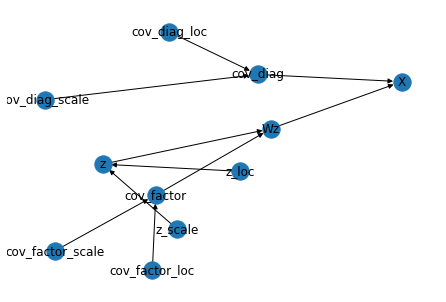

In [11]:
nx.draw(factor, with_labels=True)

In [15]:
def construct_initalization(graph, node):
    if graph.nodes[node]['node_type'] == 'param':
        return Assign(targets=[Name(id=node+'_init')],
            value=Subscript(value=Attribute(value=Name(id='self'), attr='param_init'),
                slice=Index(
                    value=JoinedStr(
                        values=[Str(s=node+'_init_'),
                            FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)]))))

In [16]:
def construct_param(graph, node):
    if graph.nodes[node]['node_type'] == 'param':
        # need to infer constraint
        if 'constraint' not in graph.nodes[node].keys():
            constraint = []
        else:
            constraint = [keyword(arg='constraint', value=Attribute(value=Name(id='constraints'), attr=graph.nodes[node]['constraint']))]
        return Assign(targets=[Name(id=node)],
                value=Call(func=Attribute(value=Name(id='pyro'), attr='param'),
                    args=[
                        JoinedStr(
                            values=[Str(s=node+'_'),
                                FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)]),
                        Name(id=node)],
                    keywords=constraint))
    elif graph.nodes[node]['node_type'] == 'const':
        return Assign(targets=[Name(id=node)], value=Num(n=graph.nodes[node]['value']))
    else:
        raise "Root nodes must be either parameters or constants."

In [18]:
def construct_sample(graph, node):
    if 'distribution' in graph.nodes[node]:
        distribution = graph.nodes[node]['distribution']
        #assert len(distribution.arg_constraints) == 2
        # assuming node is a loc-scale distribution
        loc = [edge[0] for edge in graph.in_edges(node) if graph.edges[edge]['param'] == 'loc'][0]
        scale = [edge[0] for edge in graph.in_edges(node) if graph.edges[edge]['param'] == 'scale'][0]
        # get string repr of distribution
        dist = ''.join(c for c in str(distribution).split('.')[-1] if c.isalnum())
        dist = Call(func=Attribute(value=Name(id='dist'), attr=dist),
                                args=[Name(id=loc), Name(id=scale)],
                                keywords=[])
        if graph.nodes[node]['node_type'] == 'latent':
            keywords = []
        elif graph.nodes[node]['node_type'] == 'obs':
            # assuming this is wrapped in a with pyro.plate(subsampling) as ind:
            keywords = [keyword(arg='obs',
                                value=Call(func=Attribute(value=Name(id='X'), attr='index_select'),
                                    args=[Num(n=0), Name(id='ind')],
                                    keywords=[]))]
        return Assign(targets=[Name(id=node)],
                    value=Call(func=Attribute(value=Name(id='pyro'), attr='sample'),
                        args=[
                            JoinedStr(
                                values=[Str(s=node+'_'),
                                    FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)]),
                            dist],
                        keywords=keywords))
            
    elif graph.nodes[node]['node_type'] == 'deterministic':
        # assuming function is a torch method, s.t. calling it looks like torch.method(arg1,arg2,...,argN)
        # get string repr of function
        function = graph.nodes[node]['function'].__name__
        args = [Name(id=edge[0]) for edge in graph.in_edges(node)]
        return Assign(targets=[Name(id=node)],
            value=Call(func=Attribute(value=Name(id='pyro'), attr='deterministic'),
                args=[
                    JoinedStr(
                            values=[Str(s=node+'_'),
                                FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)]),
                    Call(func=Attribute(value=Name(id='torch'), attr=function),
                        args=args,
                        keywords=[])],
                keywords=[]))

In [29]:
def construct_plate(graph, plate):
    if plate == 'N':
        keywords = [keyword(arg='size', value=Name(id='N')),
                            keyword(arg='subsample_size', value=Name(id='batch_size'))]
        optional_vars=Name(id='ind')
    else: 
        keywords = []
        optional_vars=None
    return With(
            items=[withitem(
                    context_expr=Call(func=Attribute(value=Name(id='pyro'), attr='plate'),
                        args=[
                            JoinedStr(
                                values=[Str(s=plate+'_'),
                                    FormattedValue(value=Name(id='_id'), conversion=-1, format_spec=None)]),
                            Name(id=plate[-1])],
                        keywords=keywords),
                    optional_vars=optional_vars)
                ],
            body=[Pass])

In [31]:
model = Model(torch.zeros(100,10),100,'E')
source = inspect.getsource(model.model).strip()
tree = parse(source)
# figure out which plates to create
plates = [''.join(plate) for plate in nx.get_node_attributes(factor, 'plates').values()]
new_plates = []
for plate in plates:
    if not any([other_plate.startswith(plate) for other_plate in plates if other_plate != plate]):
        new_plates.append(plate)
# create plates
for plate_config in new_plates:
    prev_plate = plate_config[0]
    AddToFunctionBody(construct_plate(factor, prev_plate), head=True).visit(tree)
    for plate in plate_config[1:]:
        AddToPlate(prev_plate, construct_plate(factor, prev_plate+plate)).visit(tree)
        prev_plate = plate
# create all nodes in DAG
for node in nx.topological_sort(factor):
    if factor.in_degree[node] == 0:
        AddToFunctionBody(construct_param(factor, node), head=True).visit(tree)
        AddToFunctionBody(construct_initalization(factor, node), head=True).visit(tree)
    else:
        if 'plates' in factor.nodes[node]:
            plate = ''.join(factor.nodes[node]['plates'])
            AddToPlate(plate, construct_sample(factor, node)).visit(tree)
        else:
            AddToFunctionBody(construct_sample(factor, node), head=True).visit(tree)
# add _id to model
AddToFunctionBody(Assign(targets=[Name(id='_id')], value=Attribute(value=Name(id='self'), attr='_id')), head=True).visit(tree)
new_source = astor.to_source(ast.parse(tree))
print(new_source)

def model(self, X):
    _id = self._id
    cov_diag_loc_init = self.param_init[f'cov_diag_loc_init_{_id}']
    cov_diag_loc = pyro.param(f'cov_diag_loc_{_id}', cov_diag_loc)
    cov_diag_scale_init = self.param_init[f'cov_diag_scale_init_{_id}']
    cov_diag_scale = pyro.param(f'cov_diag_scale_{_id}', cov_diag_scale,
        constraint=constraints.positive)
    cov_factor_loc_init = self.param_init[f'cov_factor_loc_init_{_id}']
    cov_factor_loc = pyro.param(f'cov_factor_loc_{_id}', cov_factor_loc)
    cov_factor_scale_init = self.param_init[f'cov_factor_scale_init_{_id}']
    cov_factor_scale = pyro.param(f'cov_factor_scale_{_id}',
        cov_factor_scale, constraint=constraints.positive)
    z_loc = 0.0
    z_scale = 1.0
    with pyro.plate(f'D_{_id}', D):
        with pyro.plate(f'DK_{_id}', K):
            cov_factor = pyro.sample(f'cov_factor_{_id}', dist.Normal(
                cov_factor_loc, cov_factor_scale))
        cov_diag = pyro.sample(f'cov_diag_{_id}', dist.LogNormal(
